In [1]:
import numpy as np

# Load the input data
input_data = np.load('moon-all-input.npy')

# Load the output data
output_data = np.load('moon-all-output.npy')

# Display the structure of the input data
print("Input data structure:")
print("Shape:", input_data.shape)
print("Data type:", input_data.dtype)
print("\nFirst 5 rows of input data:")
print(input_data[:5])

# Display the structure of the output data
print("\nOutput data structure:")
print("Shape:", output_data.shape)
print("Data type:", output_data.dtype)
print("\nFirst 5 rows of output data:")
print(output_data[:5])

Input data structure:
Shape: (500, 2)
Data type: float64

First 5 rows of input data:
[[ 1.53869929  0.18874413]
 [ 0.39469854  0.32372361]
 [-0.91914656  1.31188165]
 [ 1.05396355 -0.70040787]
 [ 1.04067847 -0.4373387 ]]

Output data structure:
Shape: (500,)
Data type: int64

First 5 rows of output data:
[1 0 0 1 1]


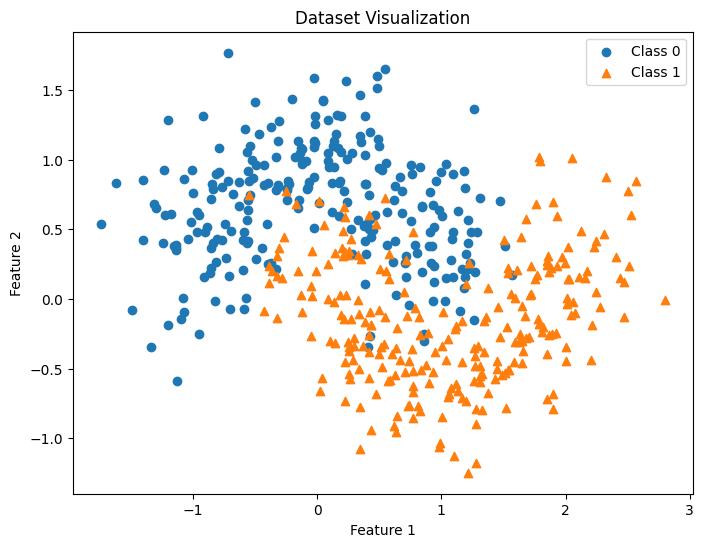

Accuracy of predicting all ones: 0.512
Accuracy of predicting all zeros: 0.488


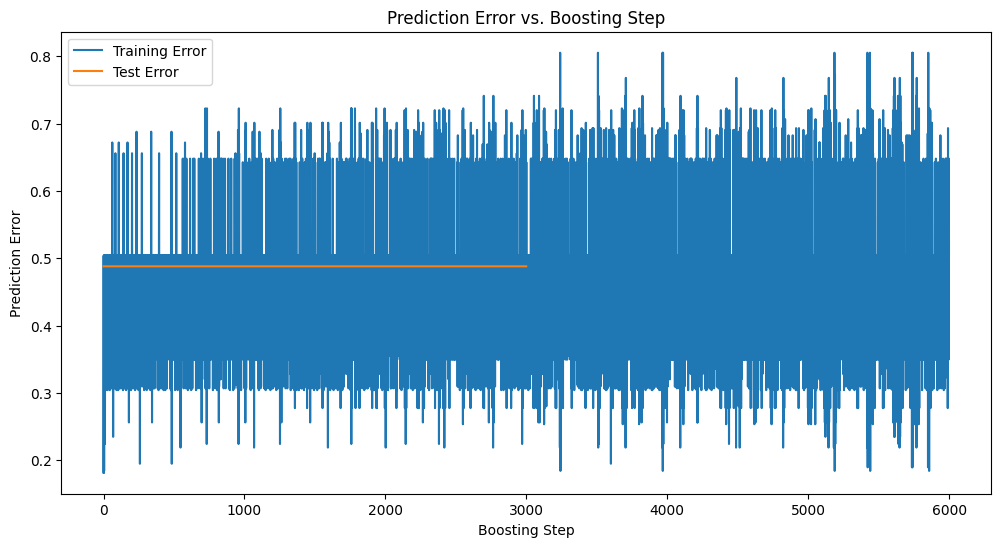

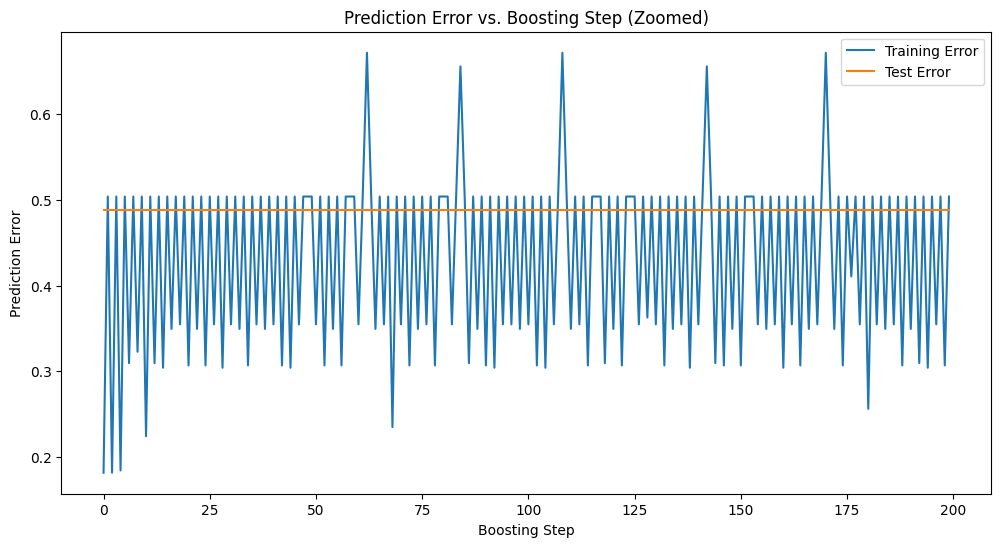

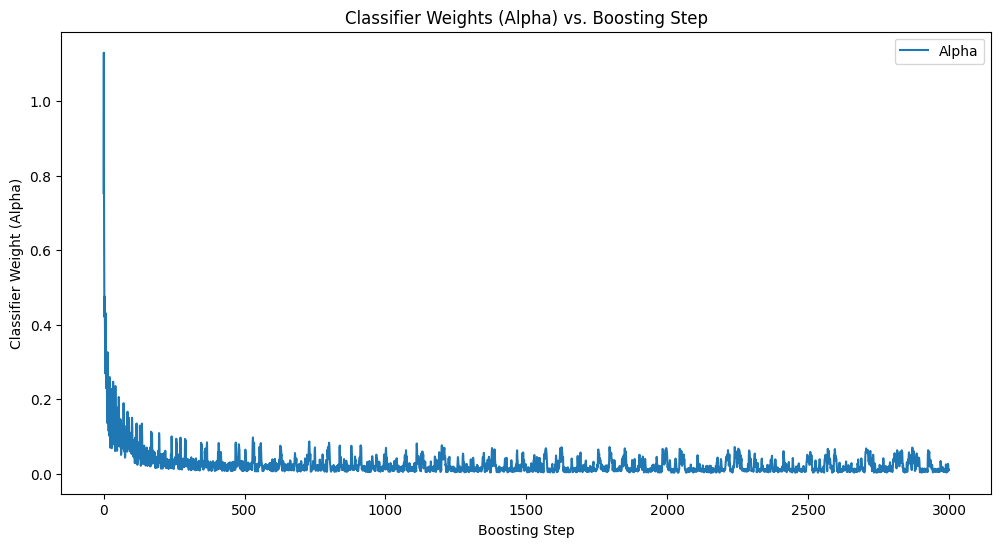

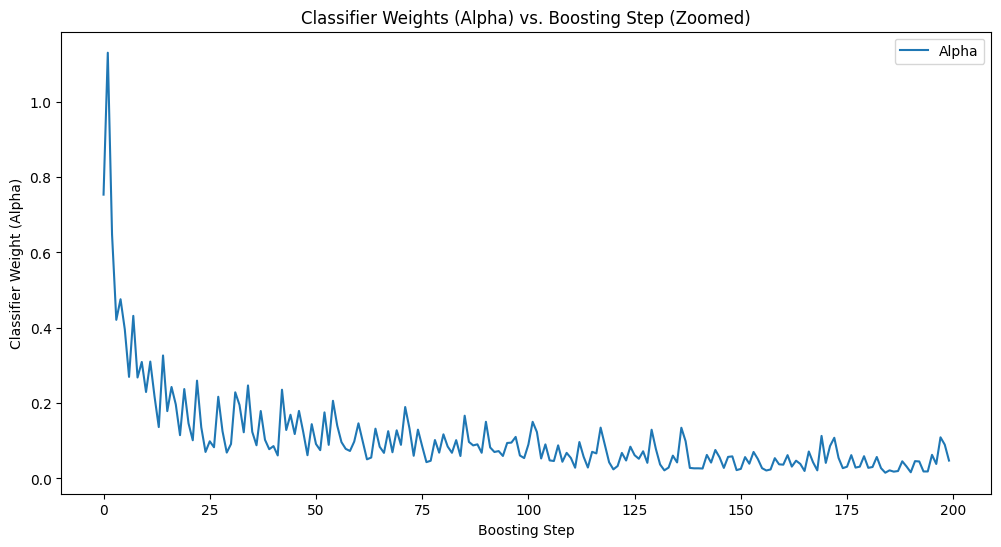

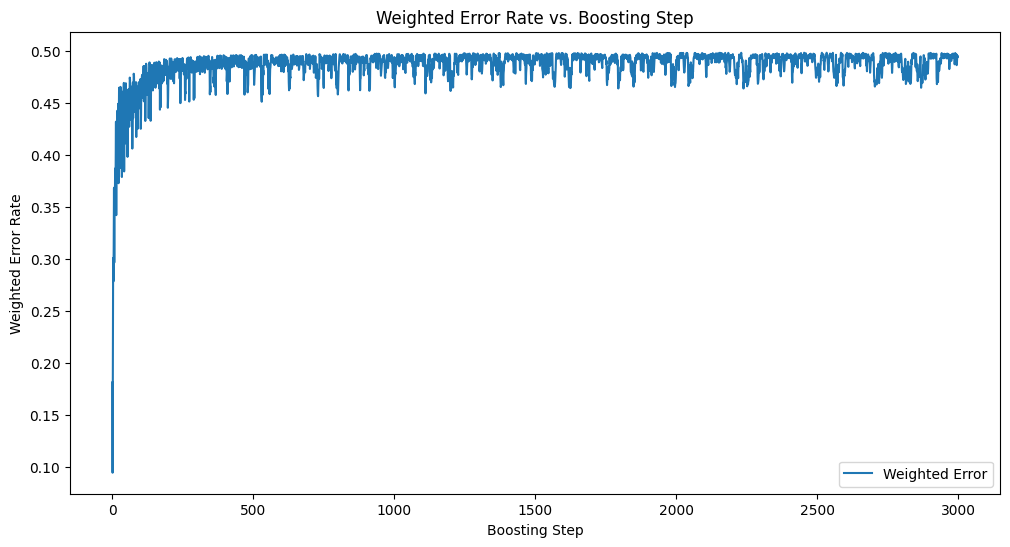

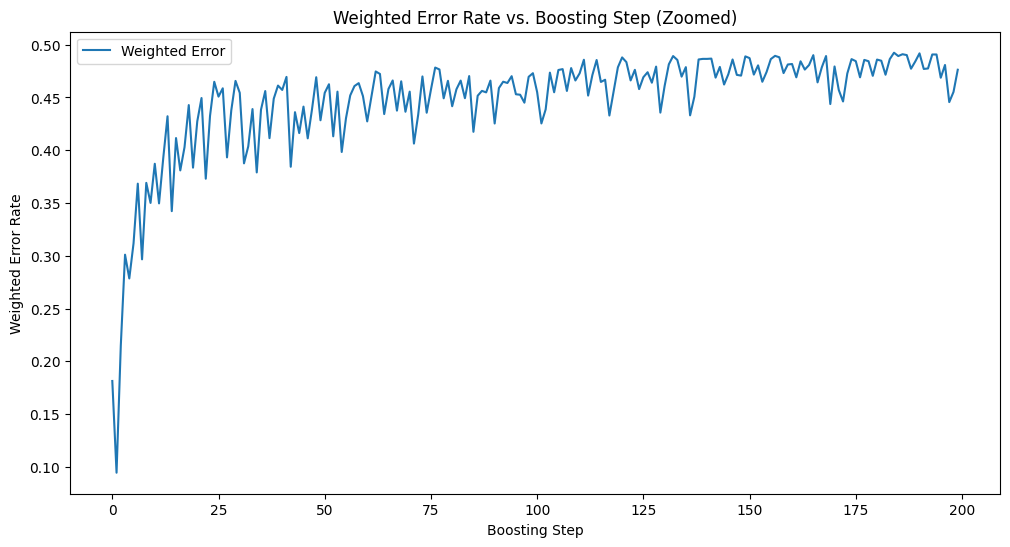

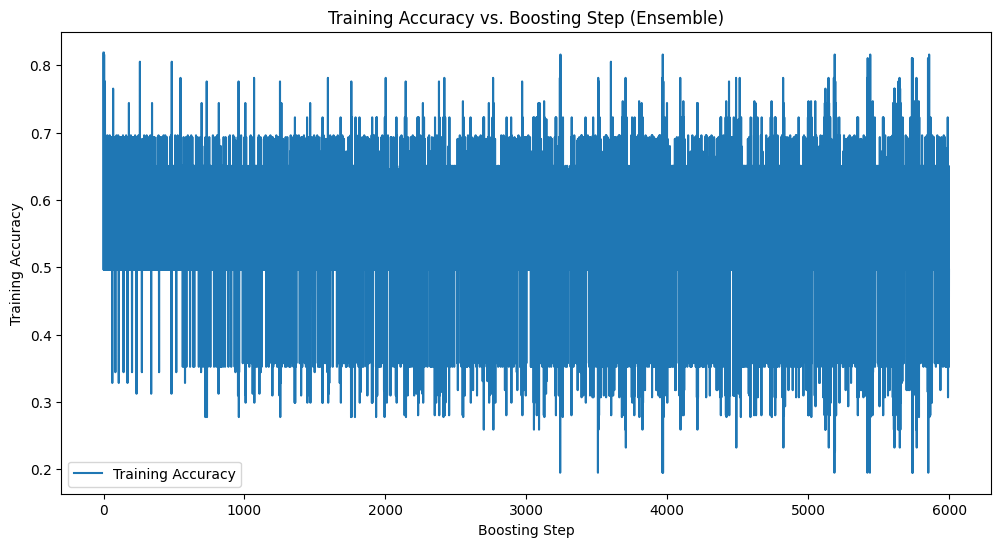

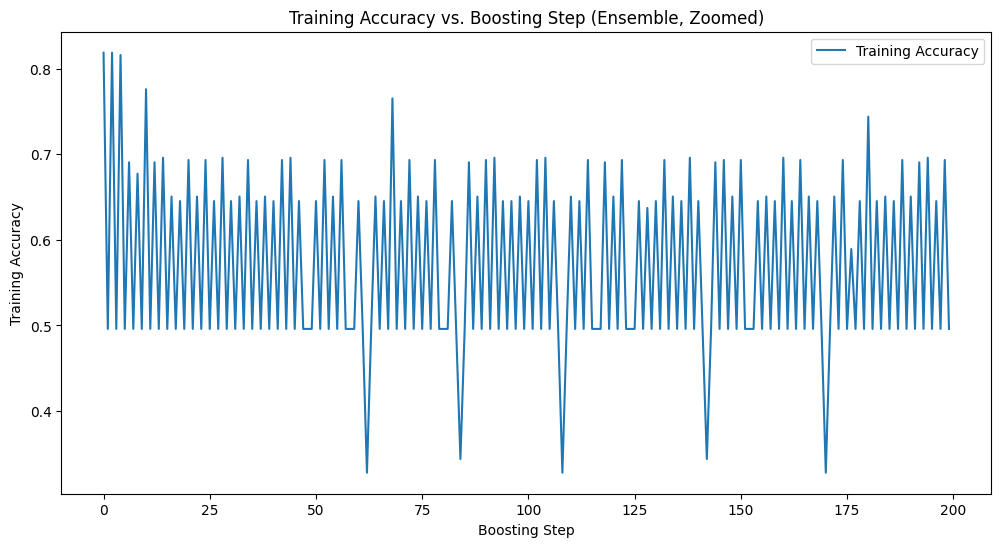

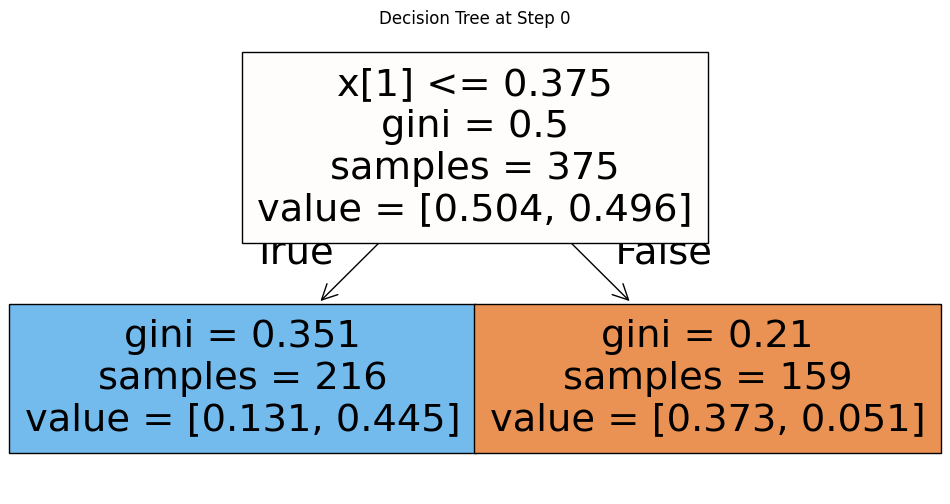

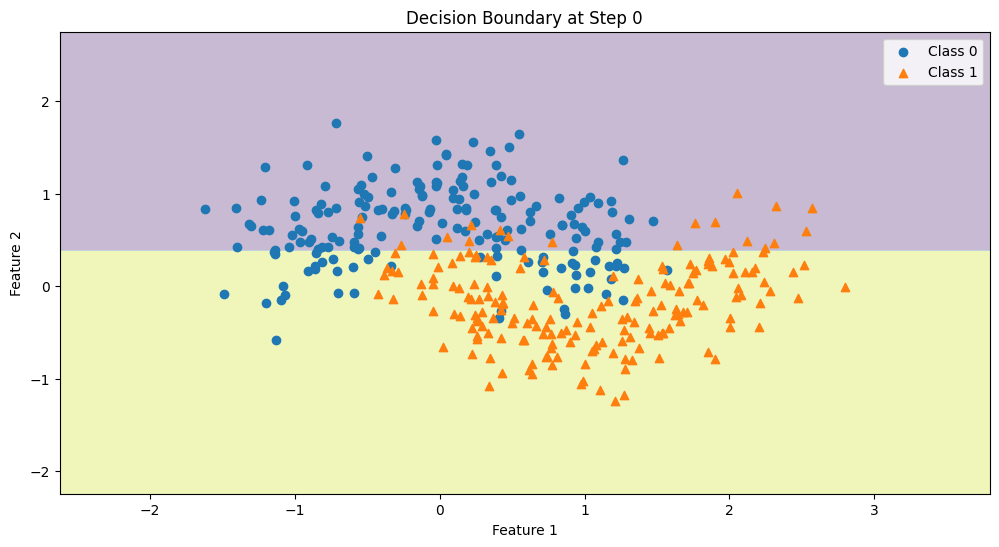

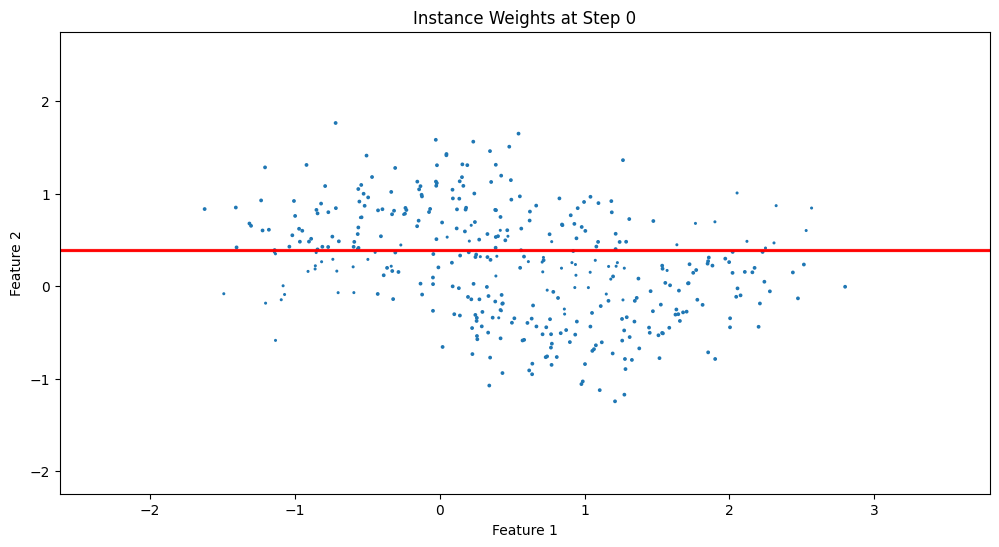

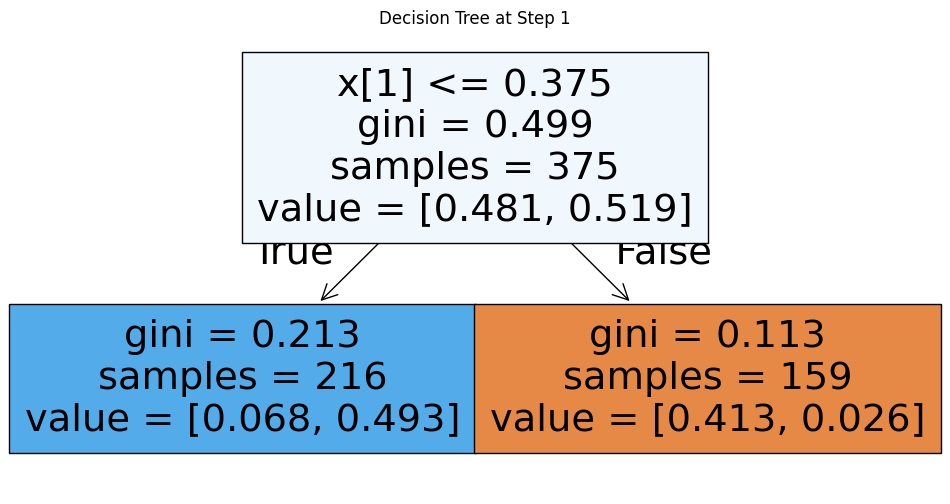

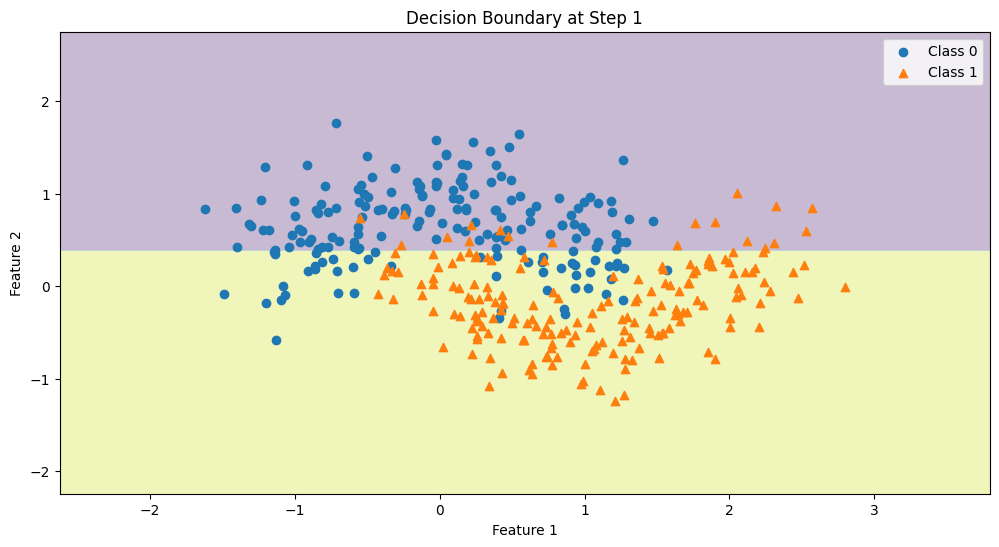

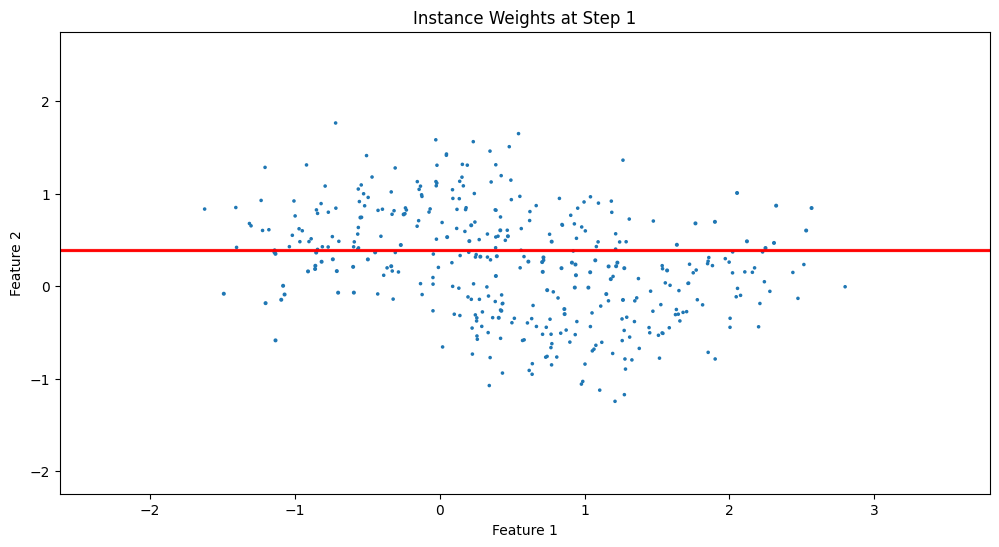

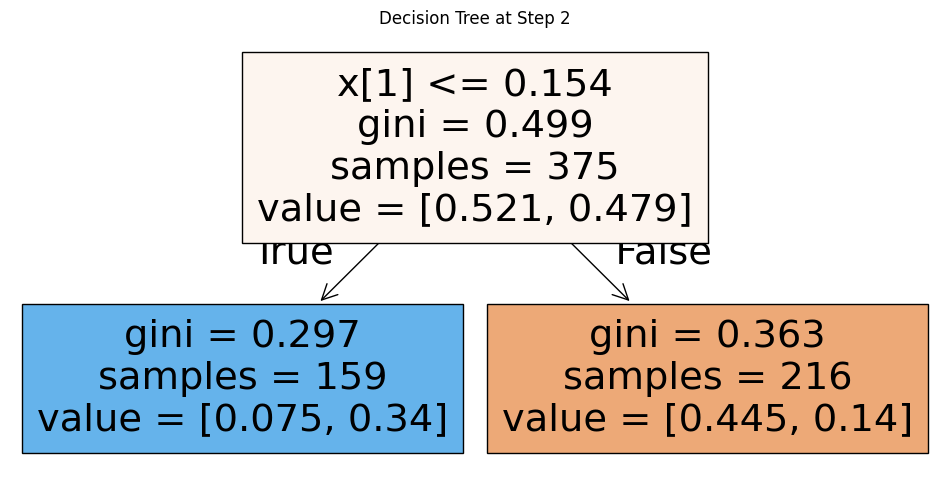

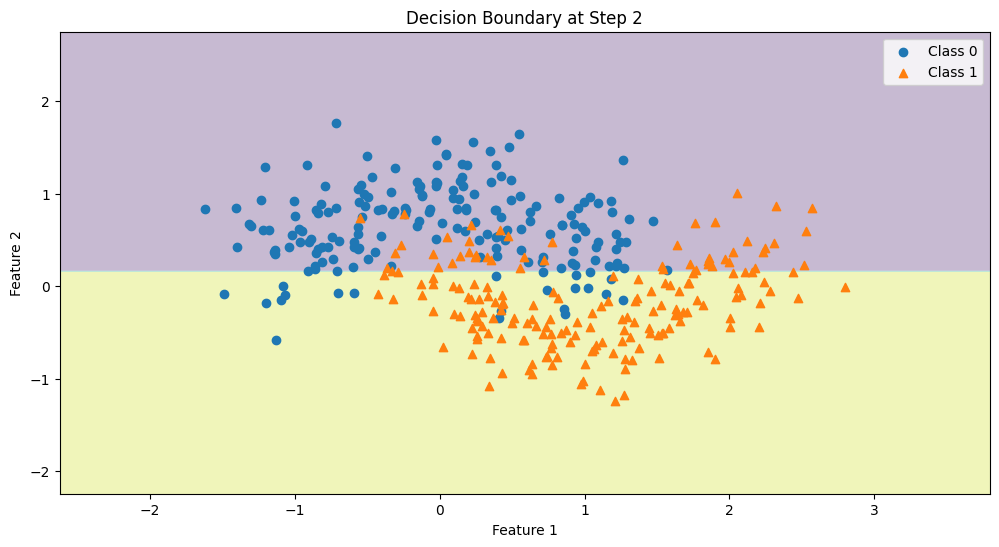

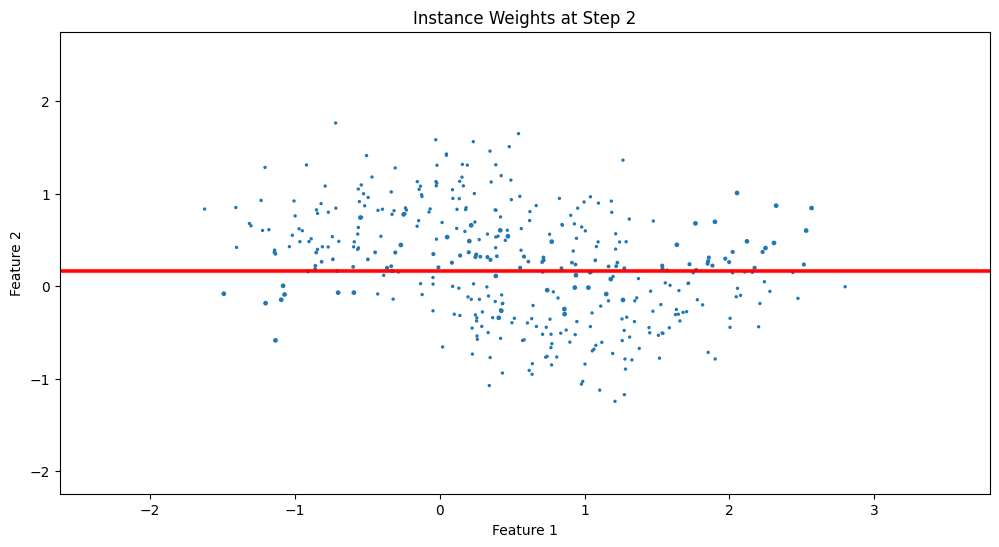

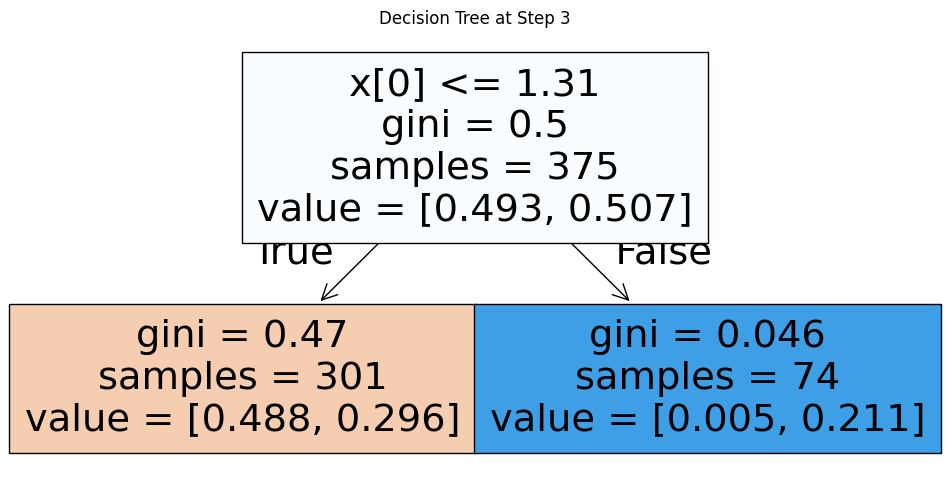

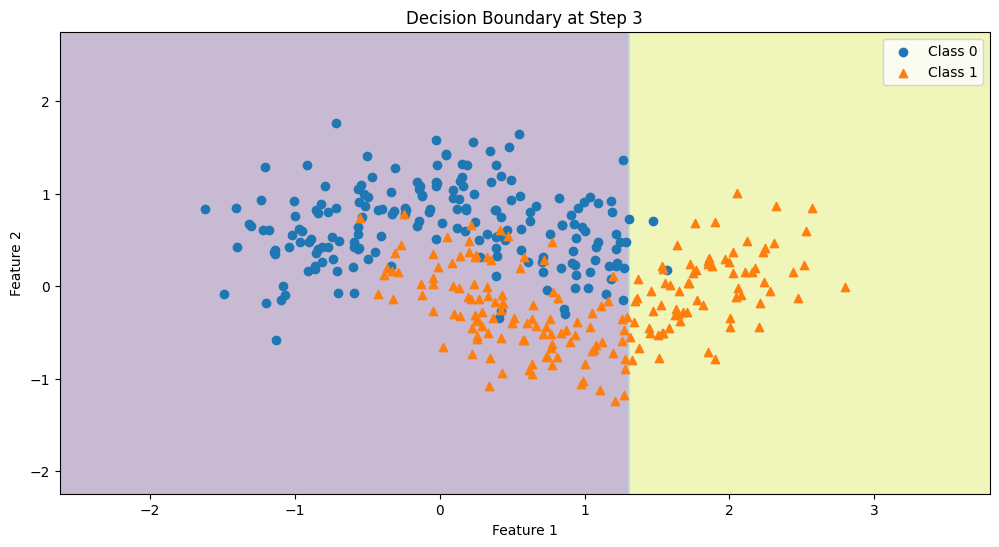

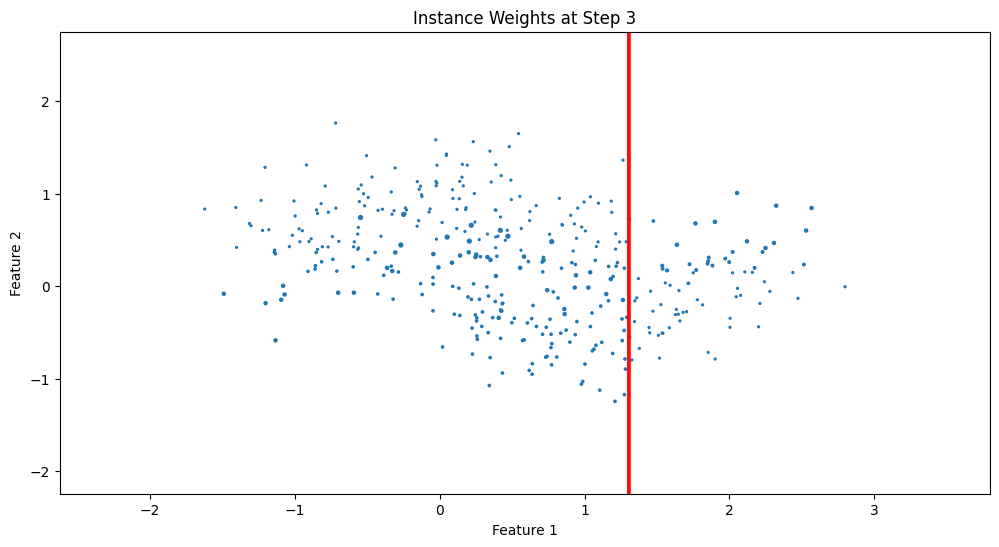

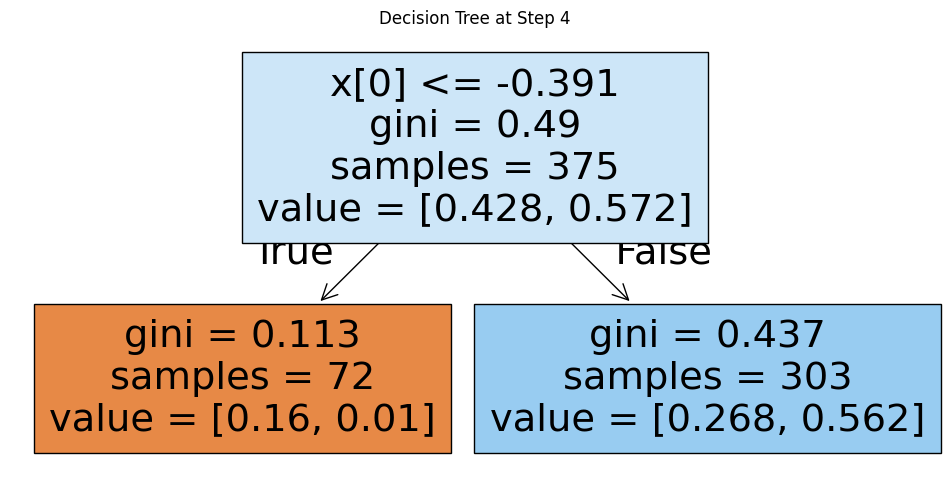

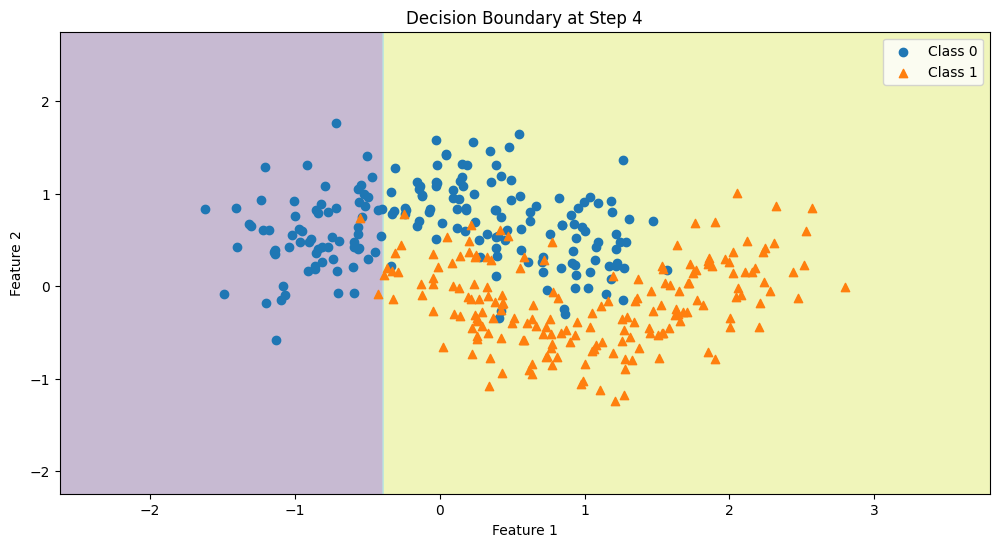

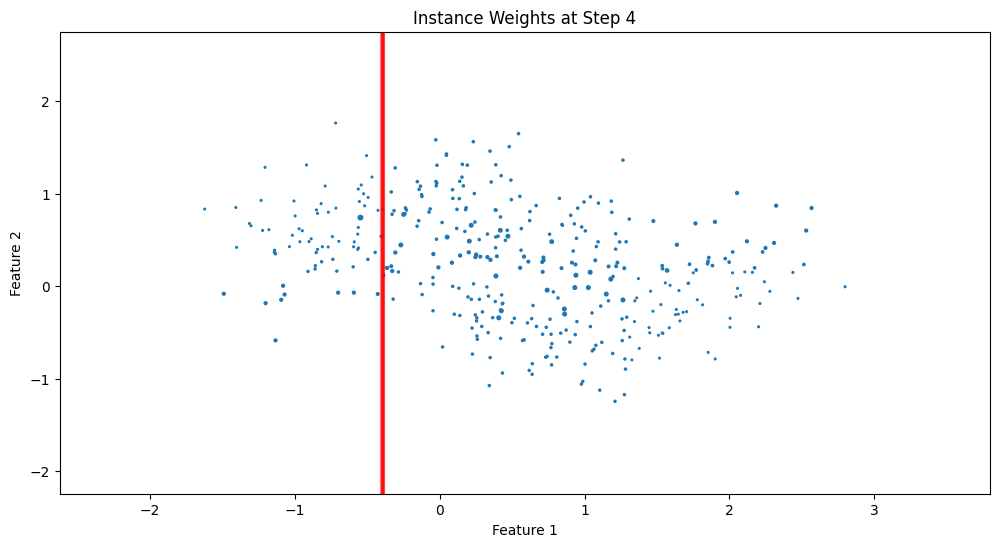

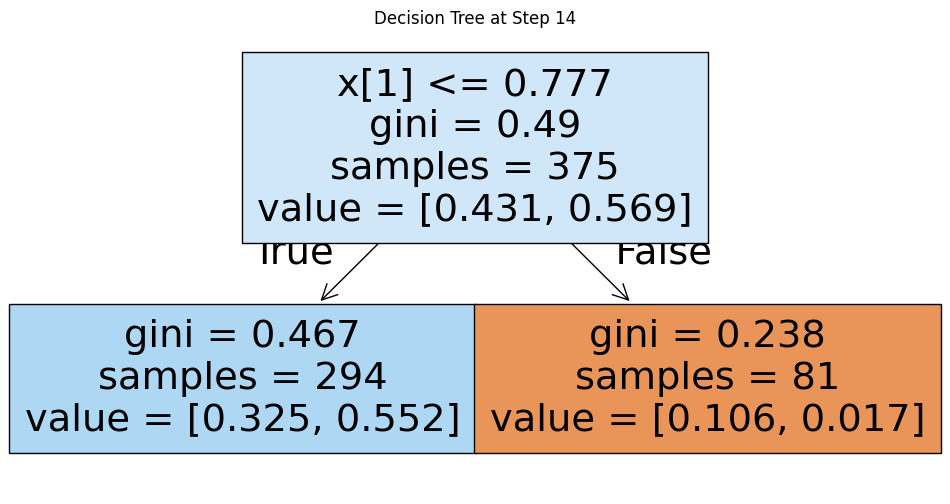

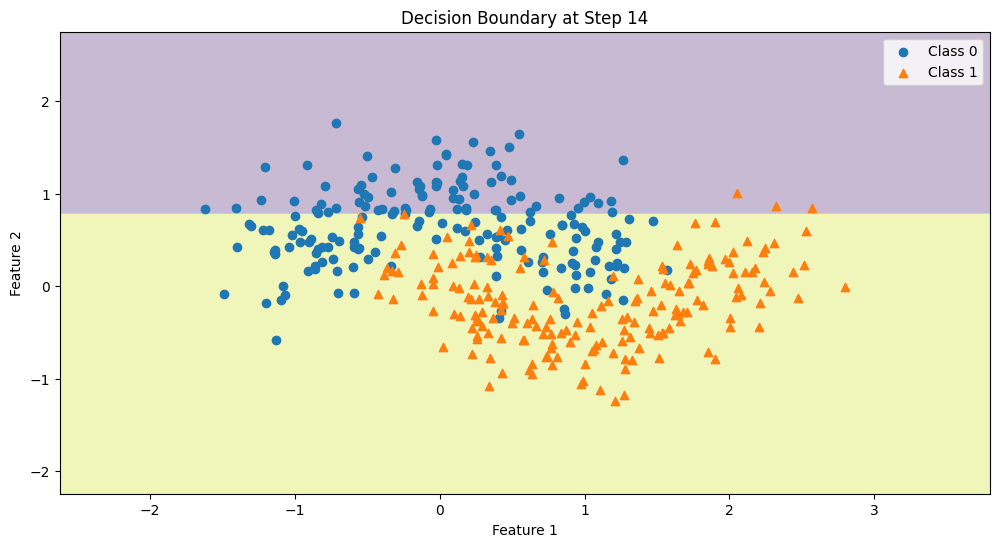

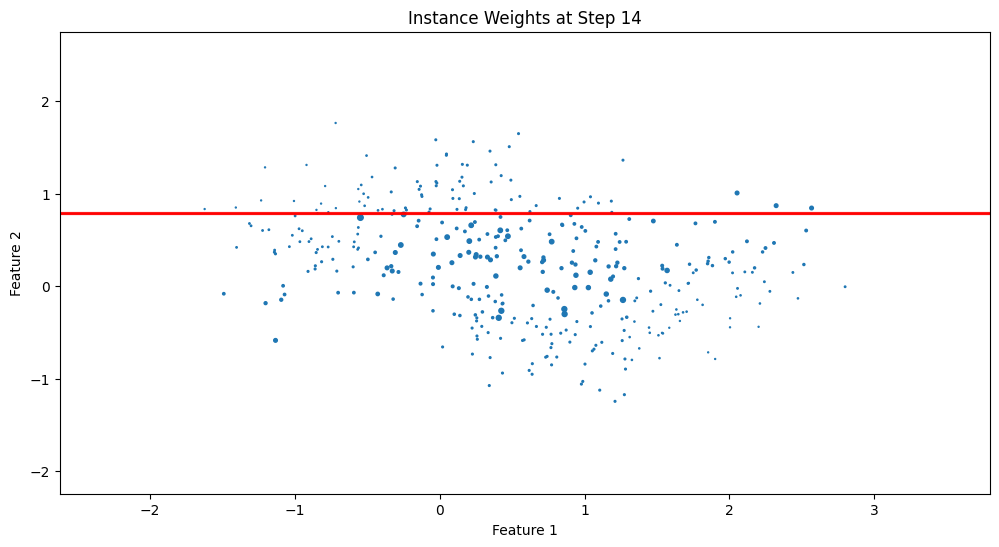

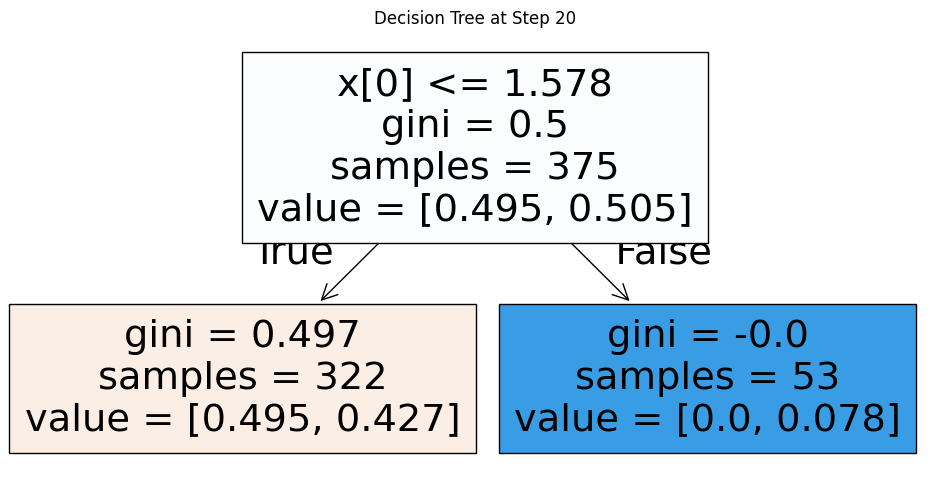

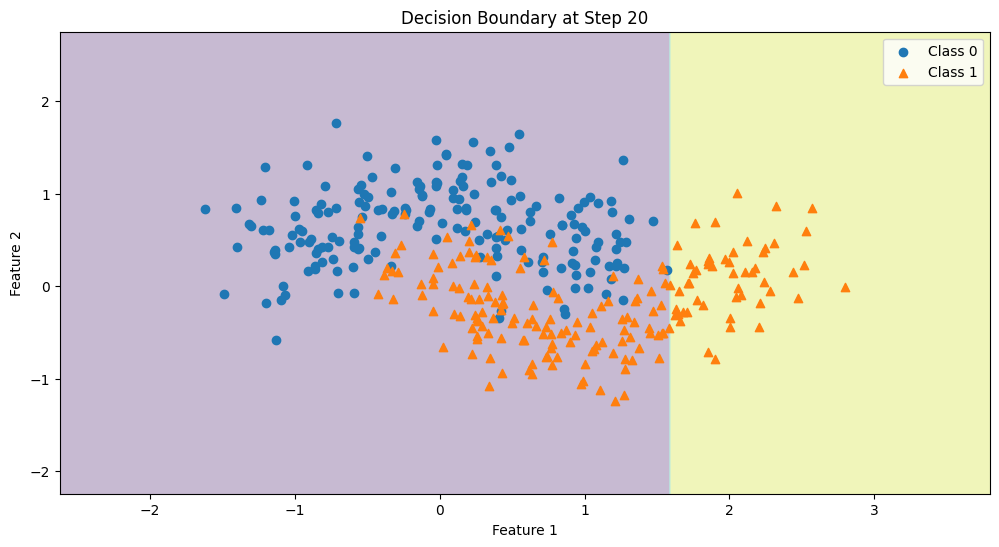

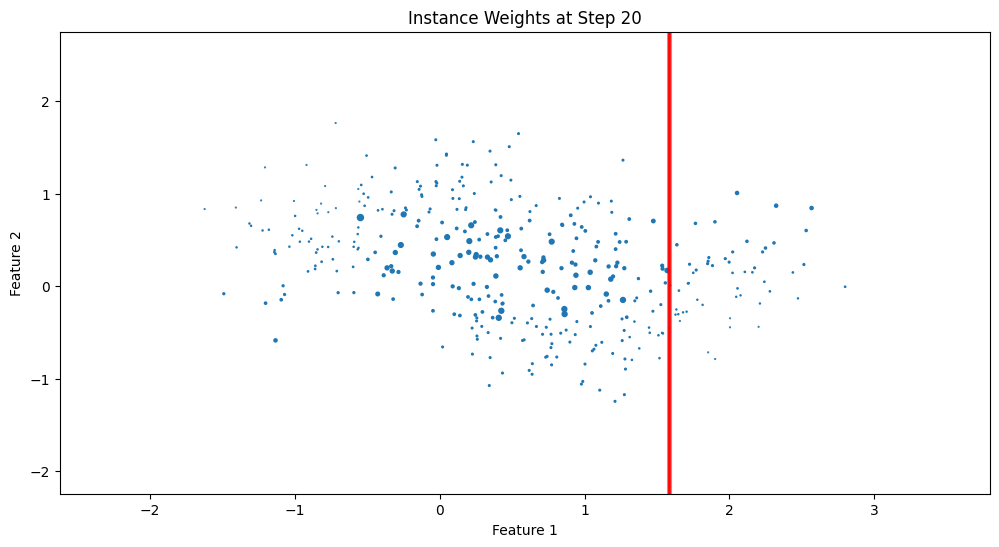

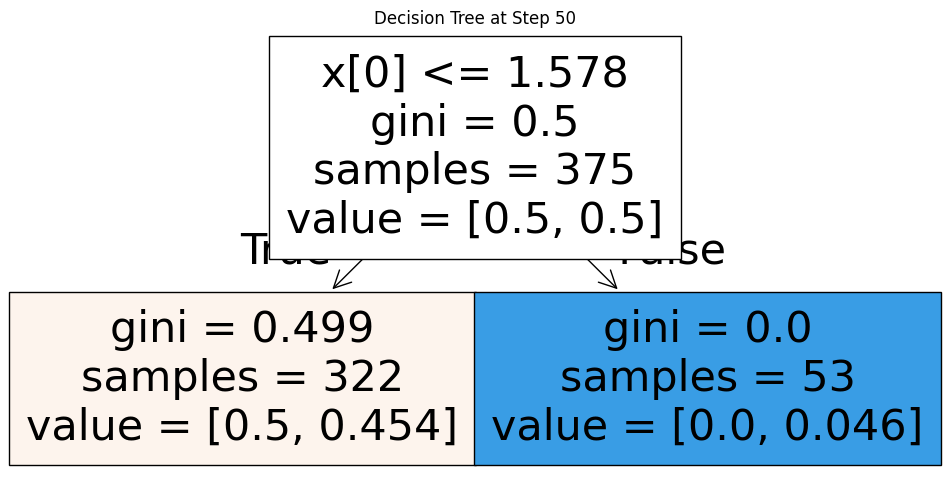

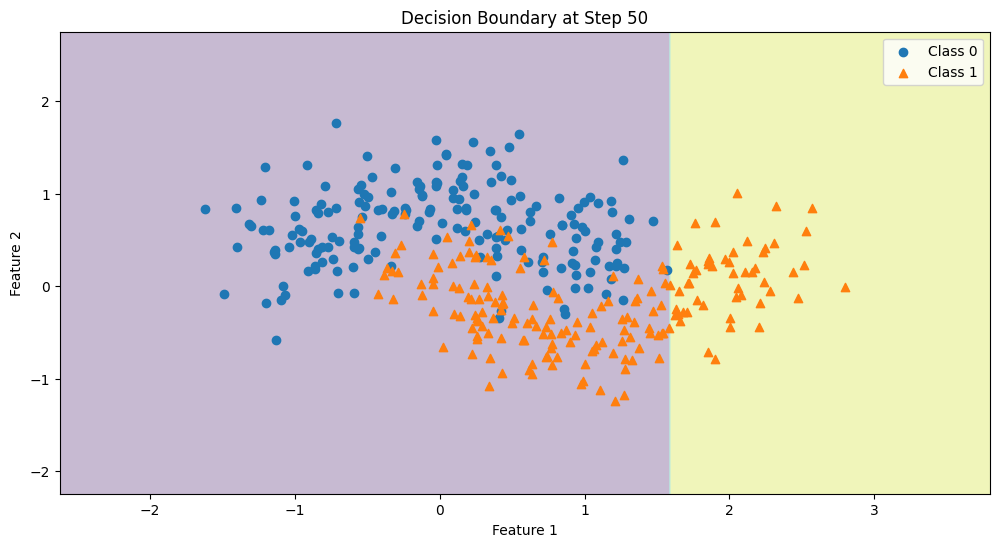

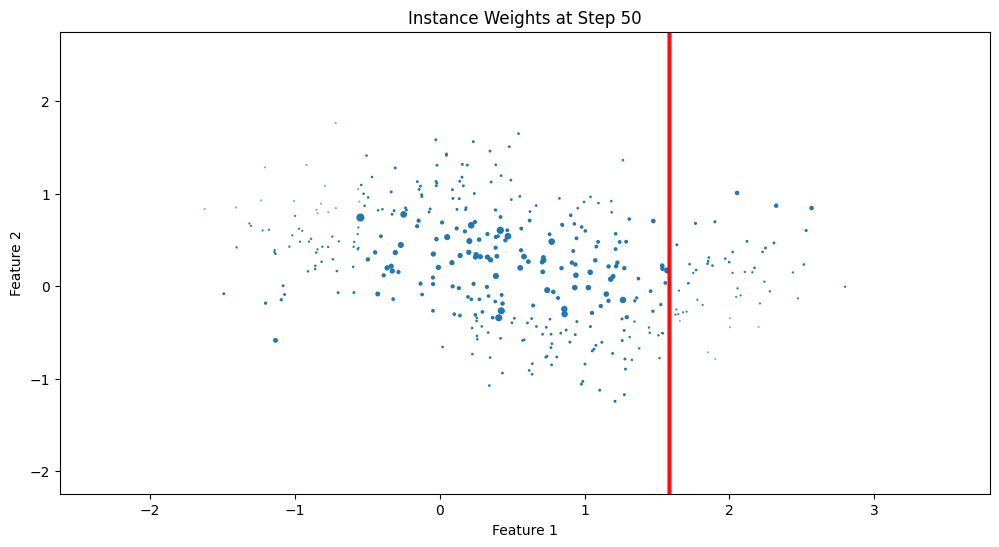

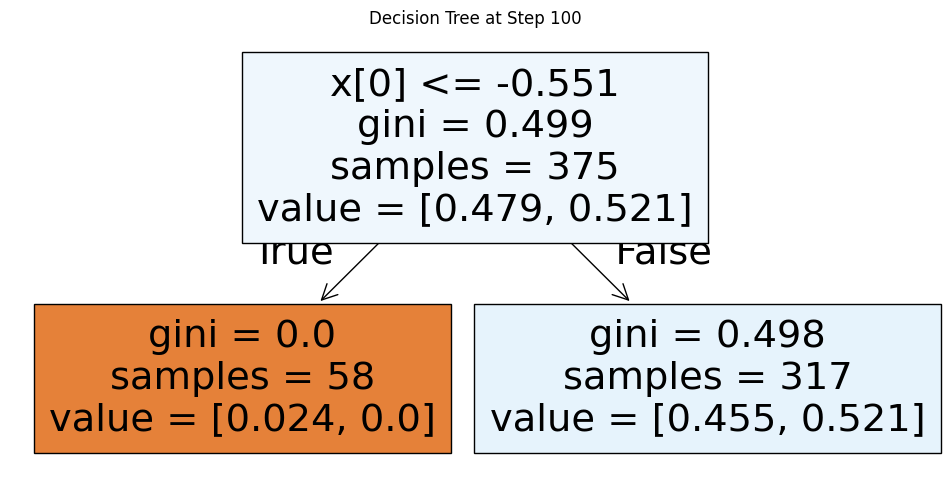

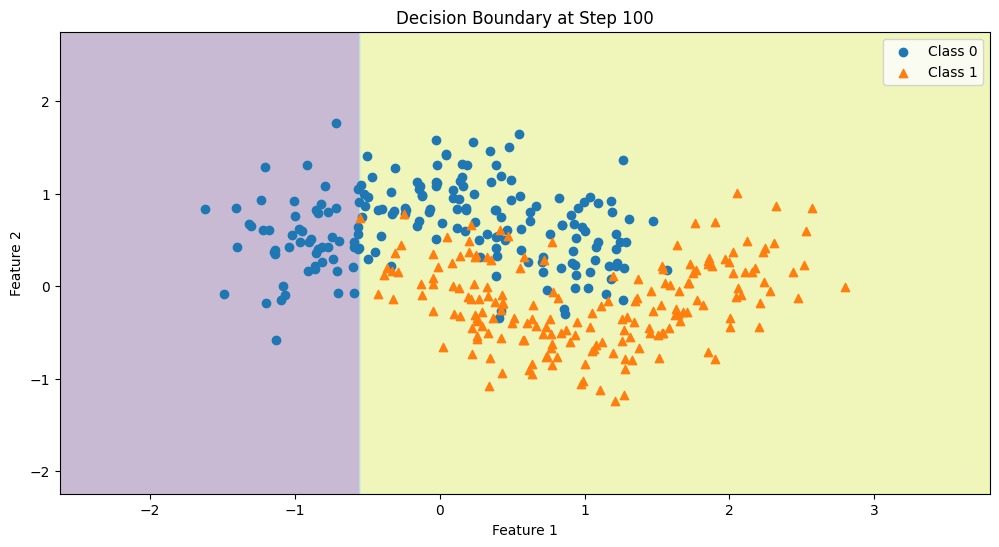

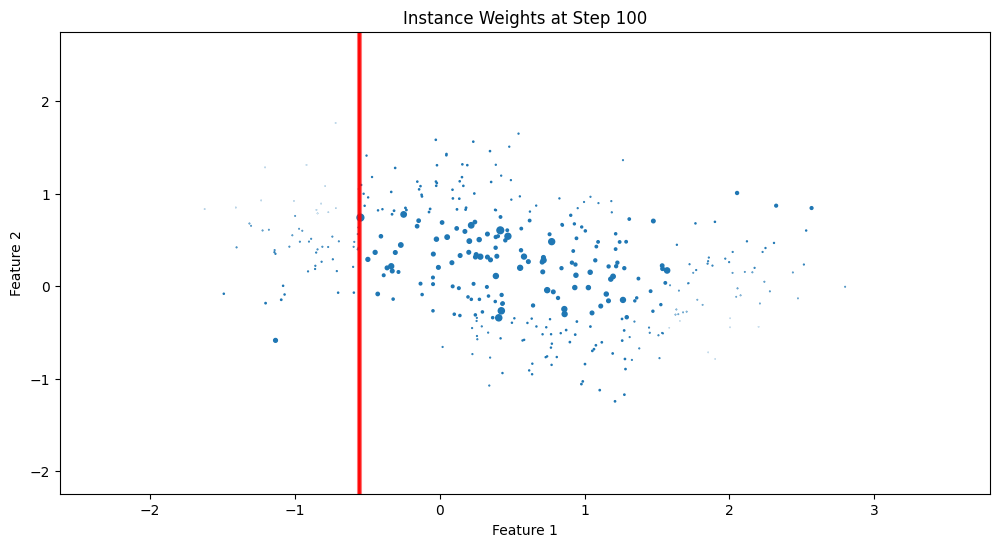

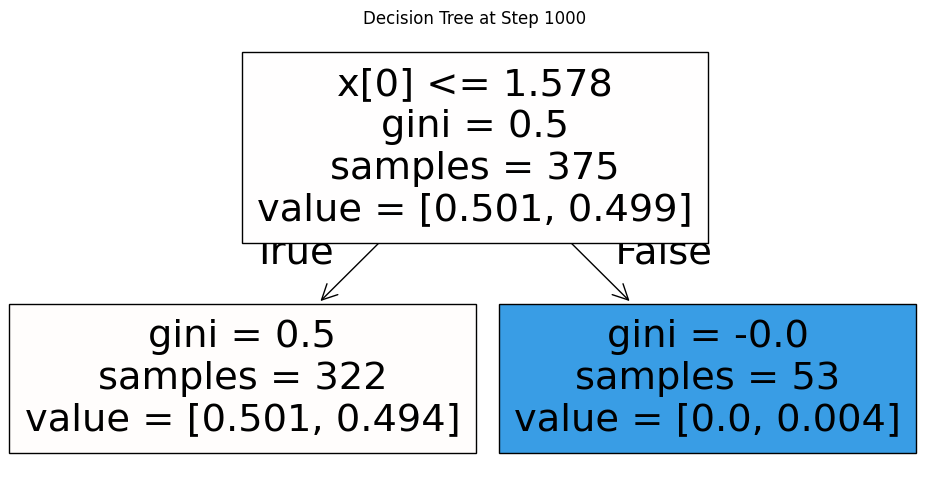

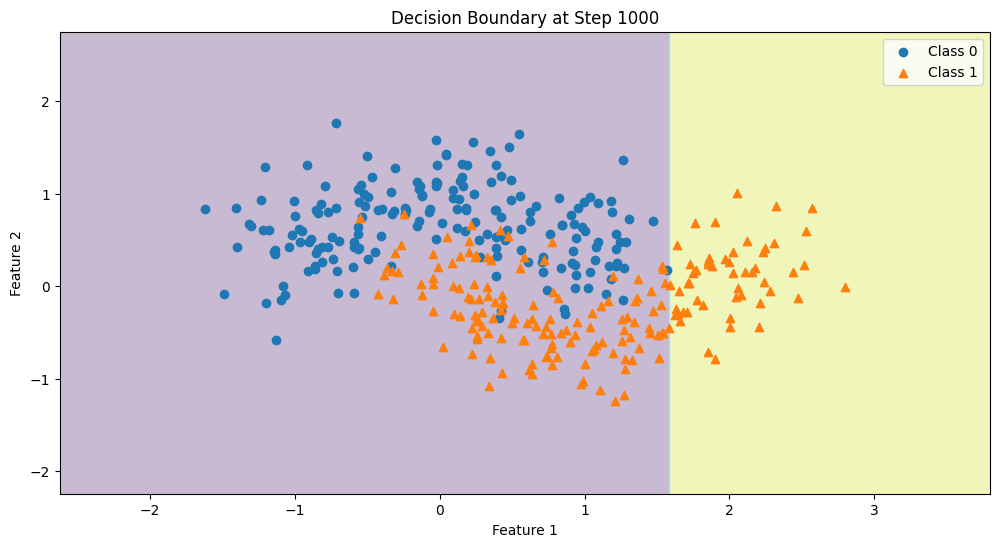

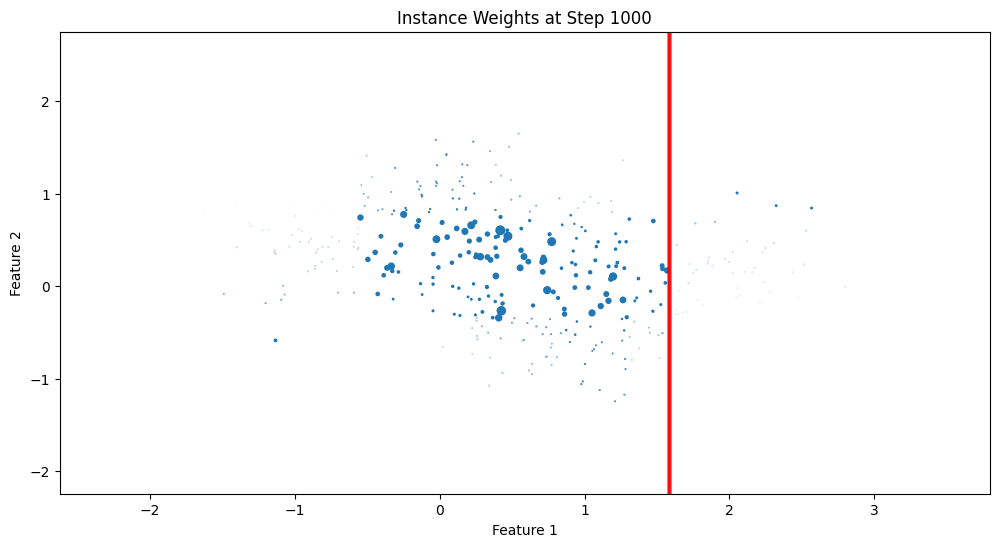

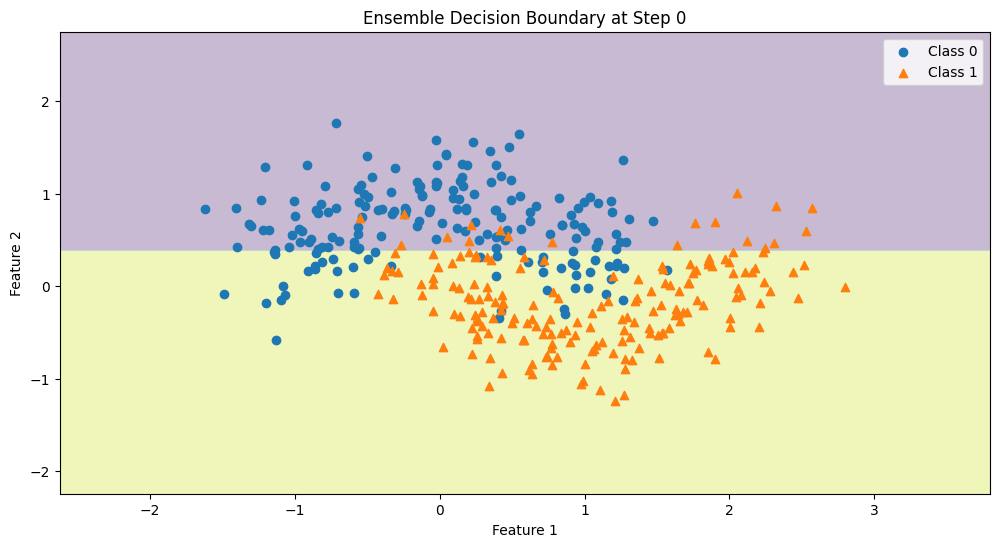

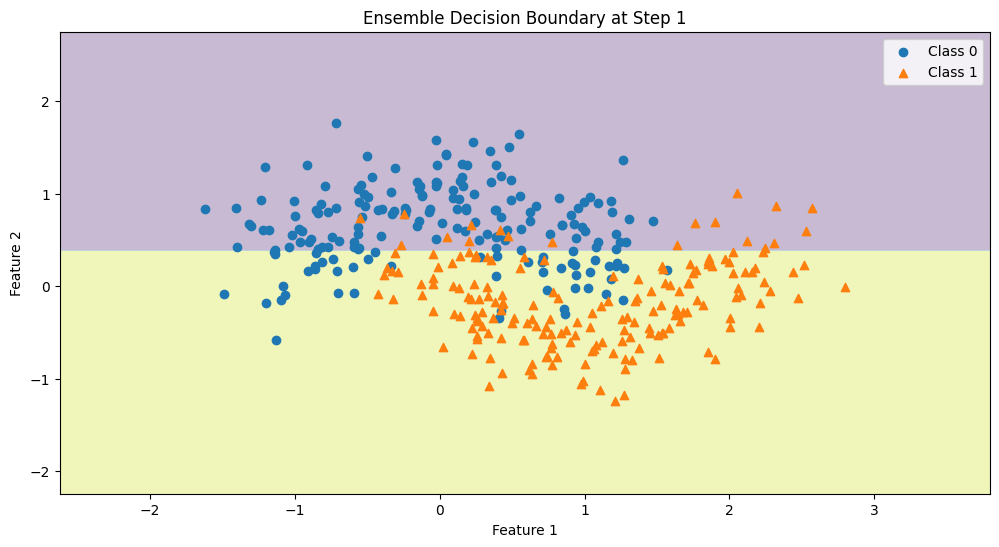

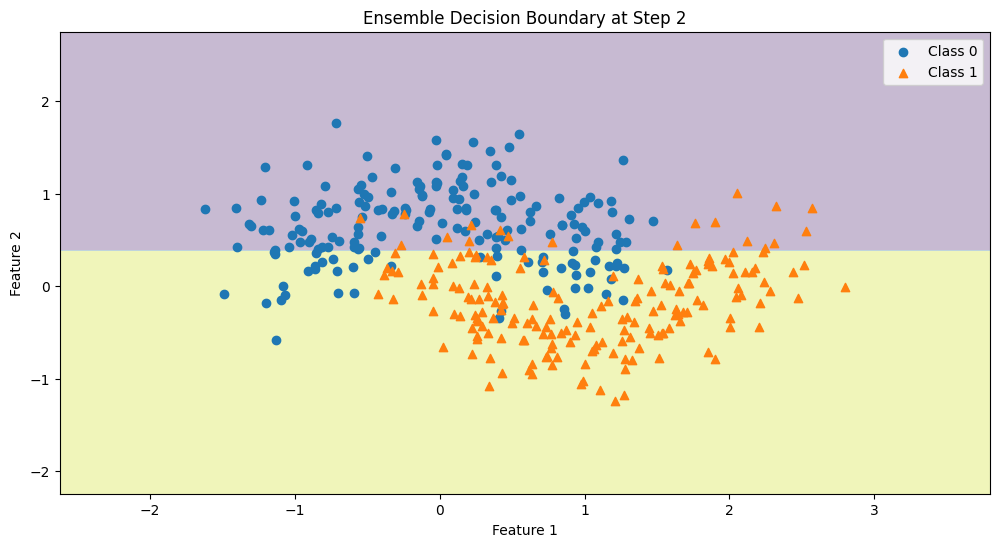

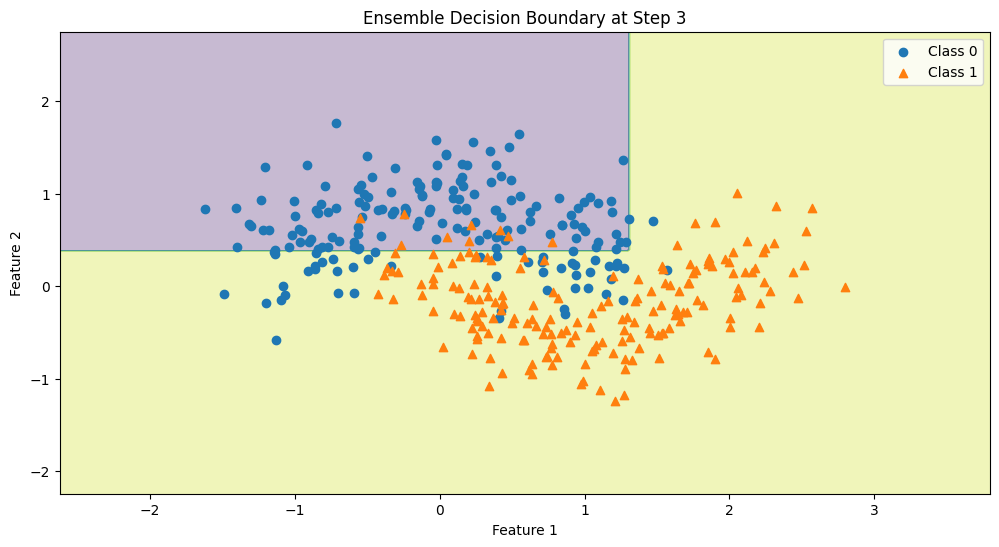

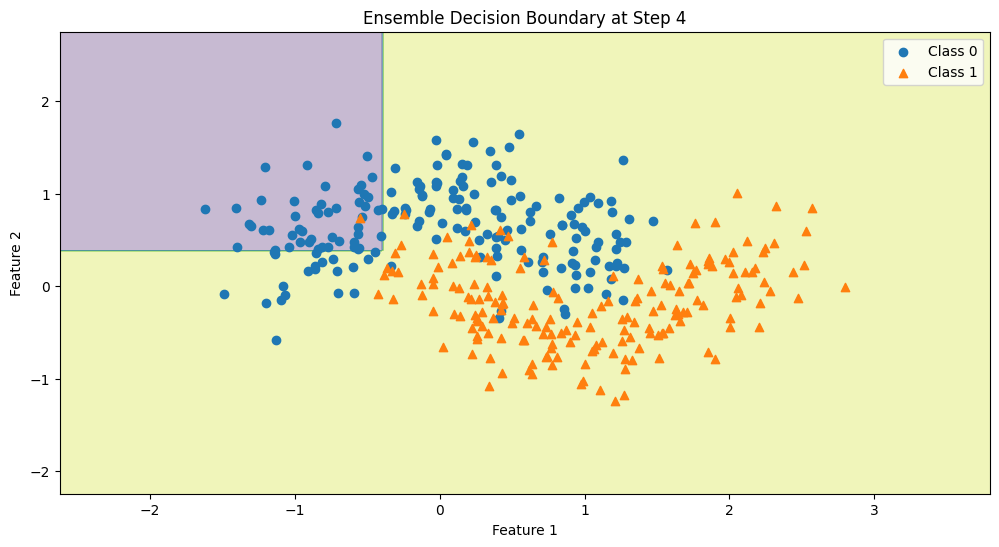

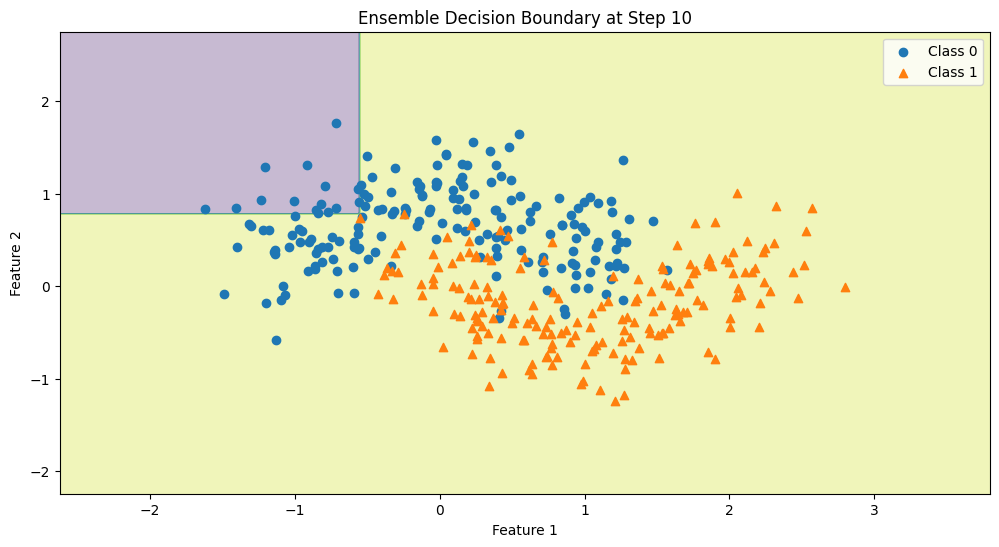

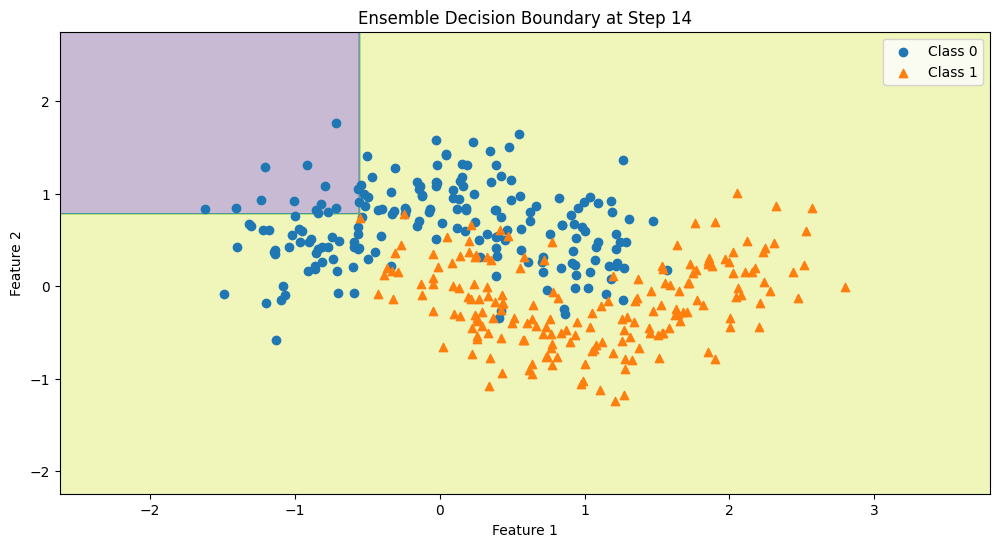

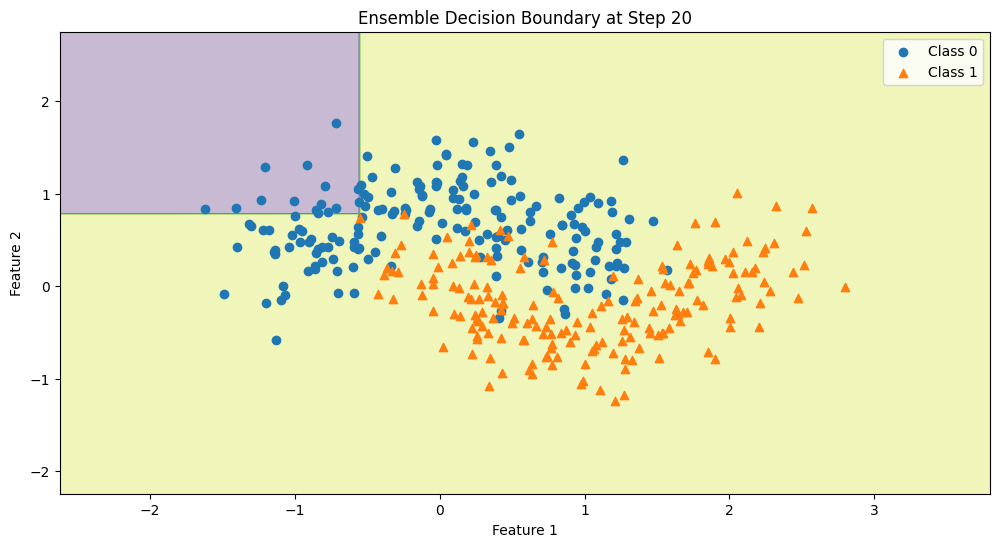

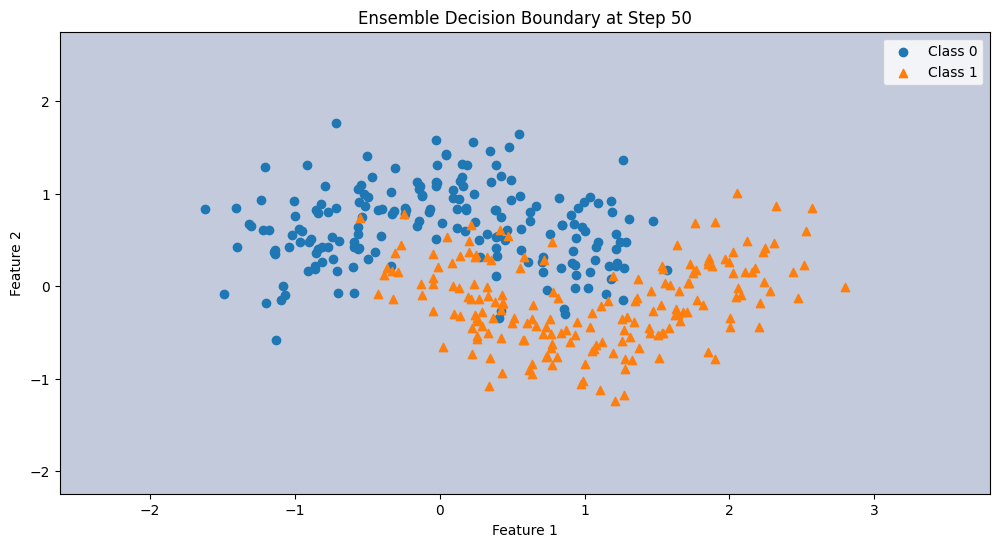

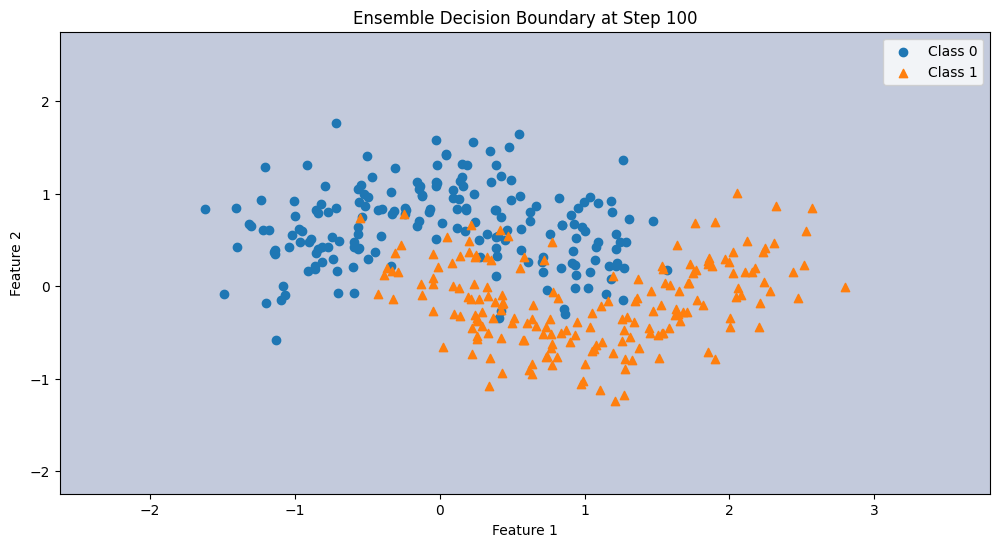

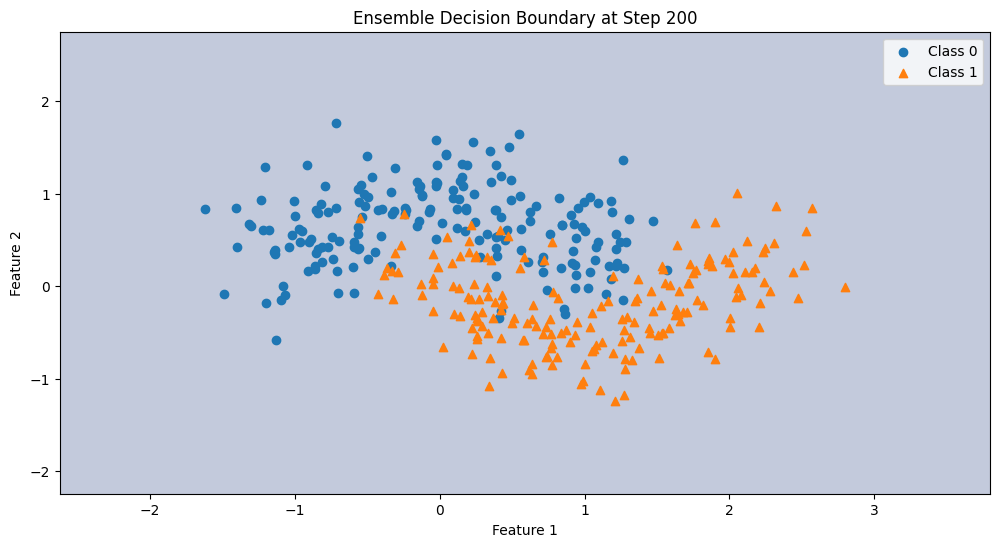

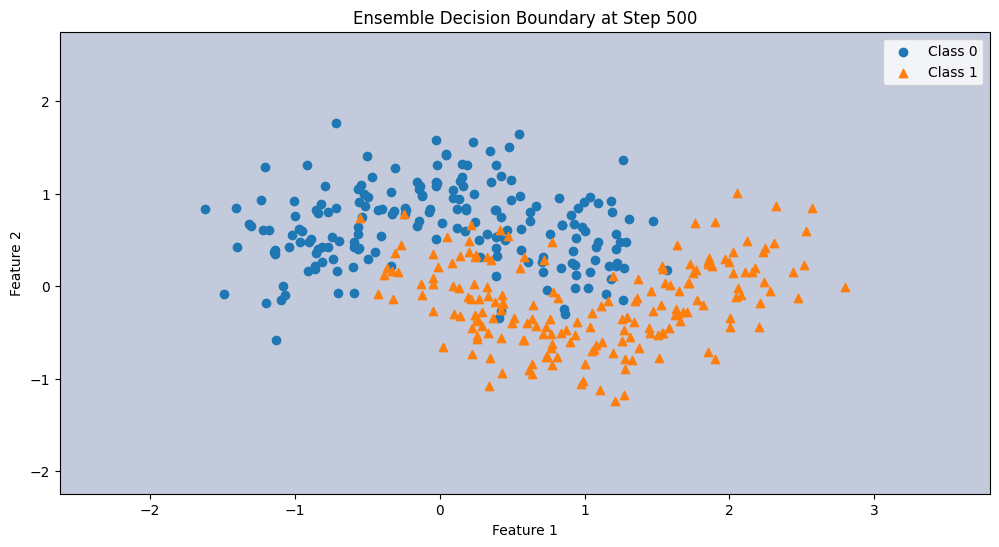

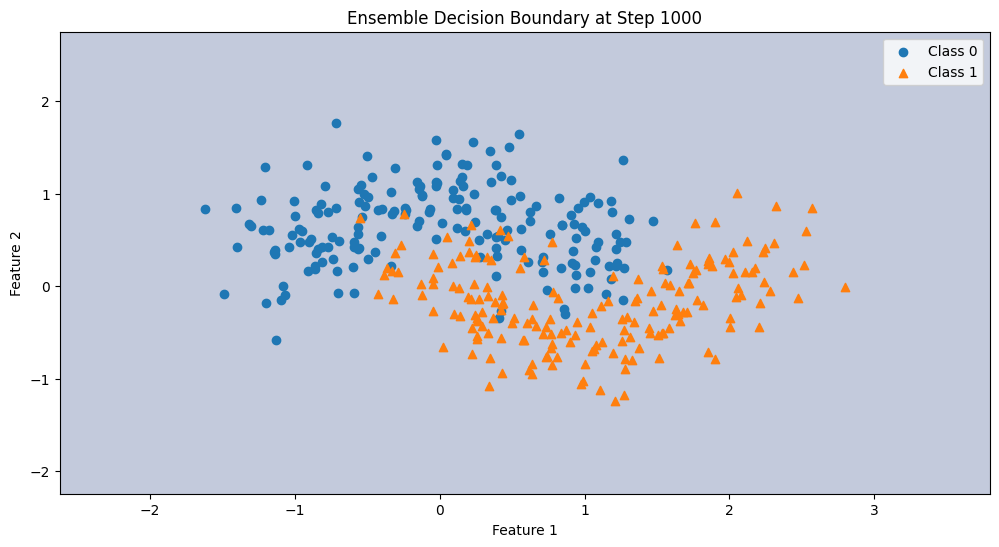

'\nDiscussion of Observations and Learned Concepts:\n\nAdaBoost Behavior:\n\n-   Error Reduction: The training error decreases rapidly in the initial boosting rounds, indicating that AdaBoost quickly learns to classify the training data effectively.\n-   Test Error Dynamics: The test error generally follows the training error but can sometimes exhibit fluctuations or even a slight increase after a certain number of boosting rounds. This phenomenon is known as "overfitting," even though AdaBoost is less prone to overfitting than other boosting algorithms.\n-   Classifier Weights (Alpha): The alpha values assigned to base classifiers vary. Classifiers with lower weighted error have higher alpha values, giving them more influence in the final decision. Some classifiers might have negative alpha, indicating they are inverted.\n-   Weighted Error: The weighted error tends to decrease as boosting progresses, showing that AdaBoost focuses on misclassified instances by adjusting instance weigh

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree

# 1. Load and Visualize the Dataset

# Load the input and output data
X = np.load('moon-all-input.npy')
y = np.load('moon-all-output.npy')

# Plot the dataset
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], label='Class 0', marker='o')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], label='Class 1', marker='^')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Dataset Visualization')
plt.legend()
plt.show()

# 2. Split the Dataset

# Split the data into training and test sets
X_train = X[:375]
y_train = y[:375]
X_test = X[375:]
y_test = y[375:]

# Verify that the test set is balanced
accuracy_test = accuracy_score(y_test, np.ones(len(y_test)))
print("Accuracy of predicting all ones:", accuracy_test)
accuracy_test = accuracy_score(y_test, np.zeros(len(y_test)))
print("Accuracy of predicting all zeros:", accuracy_test)
#The test set is reasonably balanced

# 3. Implement AdaBoost

def adaboost(X_train, y_train, X_test, y_test, n_estimators=3000):
    """
    Implements AdaBoost for binary classification.

    Args:
        X_train: Training data features.
        y_train: Training data labels.
        X_test: Test data features.
        y_test: Test data labels.
        n_estimators: Number of boosting rounds.

    Returns:
        A dictionary containing the recorded quantities.
    """

    n_samples = len(X_train)
    weights = np.full(n_samples, (1 / n_samples))  # Initialize weights
    alphas = []
    classifiers = []
    instance_weights = []
    weighted_errors = []
    training_accuracies = []
    test_accuracies = []
    training_predictions = np.zeros((n_samples, n_estimators))  # Store training predictions

    for i in range(n_estimators):
        # Train a decision stump
        clf = DecisionTreeClassifier(max_depth=1, random_state=42)
        clf.fit(X_train, y_train, sample_weight=weights)

        predictions = clf.predict(X_train)

        # Calculate weighted error
        incorrect = (predictions != y_train)
        error = np.sum(weights * incorrect)

        # Calculate alpha
        alpha = 0.5 * np.log((1 - error) / (error + 1e-10))  # Adding a small constant to avoid division by zero

        # Update weights
        weights *= np.exp(alpha * incorrect * (1 if i else -1))
        weights /= np.sum(weights)

        # Store results
        alphas.append(alpha)
        classifiers.append(clf)
        instance_weights.append(weights.copy())
        weighted_errors.append(error)
        training_accuracies.append(accuracy_score(y_train, predictions))

        # Calculate ensemble predictions and accuracy
        training_predictions[:, i] = predictions  # Store predictions for each classifier
        ensemble_predictions_train = np.sign(np.dot(training_predictions[:, :i+1], alphas[:i+1]))
        ensemble_predictions_train[ensemble_predictions_train == 0] = 1 # Replace zeros with ones
        training_accuracy = accuracy_score(y_train, ensemble_predictions_train)
        training_accuracies.append(training_accuracy)

        #test predictions
        test_predictions = np.zeros((len(X_test), i+1))
        for j in range(i+1):
          test_predictions[:, j] = classifiers[j].predict(X_test)
        ensemble_predictions_test = np.sign(np.dot(test_predictions, alphas[:i+1]))
        ensemble_predictions_test[ensemble_predictions_test == 0] = 1
        test_accuracy = accuracy_score(y_test, ensemble_predictions_test)
        test_accuracies.append(test_accuracy)

    return {
        'alphas': alphas,
        'classifiers': classifiers,
        'instance_weights': instance_weights,
        'weighted_errors': weighted_errors,
        'training_accuracies': training_accuracies,
        'test_accuracies': test_accuracies,
        'training_predictions': training_predictions # Return training predictions
    }

# Run AdaBoost
adaboost_results = adaboost(X_train, y_train, X_test, y_test)

# 4. Plot Prediction Errors

plt.figure(figsize=(12, 6))
plt.plot(1 - np.array(adaboost_results['training_accuracies']), label='Training Error')
plt.plot(1 - np.array(adaboost_results['test_accuracies']), label='Test Error')
plt.xlabel('Boosting Step')
plt.ylabel('Prediction Error')
plt.title('Prediction Error vs. Boosting Step')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(1 - np.array(adaboost_results['training_accuracies'][:200]), label='Training Error')
plt.plot(1 - np.array(adaboost_results['test_accuracies'][:200]), label='Test Error')
plt.xlabel('Boosting Step')
plt.ylabel('Prediction Error')
plt.title('Prediction Error vs. Boosting Step (Zoomed)')
plt.legend()
plt.show()

# 5. Plot Classifier Weights (alpha)

plt.figure(figsize=(12, 6))
plt.plot(adaboost_results['alphas'], label='Alpha')
plt.xlabel('Boosting Step')
plt.ylabel('Classifier Weight (Alpha)')
plt.title('Classifier Weights (Alpha) vs. Boosting Step')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(adaboost_results['alphas'][:200], label='Alpha')
plt.xlabel('Boosting Step')
plt.ylabel('Classifier Weight (Alpha)')
plt.title('Classifier Weights (Alpha) vs. Boosting Step (Zoomed)')
plt.legend()
plt.show()

# 6. Plot Weighted Error Rates

plt.figure(figsize=(12, 6))
plt.plot(adaboost_results['weighted_errors'], label='Weighted Error')
plt.xlabel('Boosting Step')
plt.ylabel('Weighted Error Rate')
plt.title('Weighted Error Rate vs. Boosting Step')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(adaboost_results['weighted_errors'][:200], label='Weighted Error')
plt.xlabel('Boosting Step')
plt.ylabel('Weighted Error Rate')
plt.title('Weighted Error Rate vs. Boosting Step (Zoomed)')
plt.legend()
plt.show()

# 7. Plot Training Accuracies for Base Classifiers

plt.figure(figsize=(12, 6))
plt.plot(adaboost_results['training_accuracies'], label='Training Accuracy')
plt.xlabel('Boosting Step')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy vs. Boosting Step (Ensemble)')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(adaboost_results['training_accuracies'][:200], label='Training Accuracy')
plt.xlabel('Boosting Step')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy vs. Boosting Step (Ensemble, Zoomed)')
plt.legend()
plt.show()

# 8. Visualize Decision Trees and Instance Weights

indices_to_plot = [0, 1, 2, 3, 4, 14, 20, 50, 100, 1000]
for i in indices_to_plot:
    plt.figure(figsize=(12, 6))
    plot_tree(adaboost_results['classifiers'][i], filled=True)
    plt.title(f'Decision Tree at Step {i}')
    plt.show()

    #plot decision boundary
    plt.figure(figsize=(12, 6))
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))
    Z = adaboost_results['classifiers'][i].predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1], label='Class 0', marker='o')
    plt.scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1], label='Class 1', marker='^')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(f'Decision Boundary at Step {i}')
    plt.legend()
    plt.show()

    #plot weights
    plt.figure(figsize=(12, 6))
    weights = adaboost_results['instance_weights'][i]
    #scale weights for better visualization
    scaled_weights = weights * 1000
    plt.scatter(X_train[:, 0], X_train[:, 1], s=scaled_weights)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(f'Instance Weights at Step {i}')

    #plot decision boundary
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))
    Z = adaboost_results['classifiers'][i].predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, alpha=0.5, colors='red')

    plt.show()

# 9. Plot Decision Boundaries for Ensemble Models

indices_to_plot = [0, 1, 2, 3, 4, 10, 14, 20, 50, 100, 200, 500, 1000]
for i in indices_to_plot:
    plt.figure(figsize=(12, 6))
    #Calculate ensemble predictions
    ensemble_predictions_train = np.sign(np.dot(adaboost_results['training_predictions'][:, :i+1], adaboost_results['alphas'][:i+1]))
    ensemble_predictions_train[ensemble_predictions_train == 0] = 1 # Replace zeros with ones

    # Plot decision boundary
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))
    #calculate predictions for meshgrid points
    test_predictions = np.zeros((len(xx.ravel()), i+1))
    for j in range(i+1):
      test_predictions[:, j] = adaboost_results['classifiers'][j].predict(np.c_[xx.ravel(), yy.ravel()])
    Z = np.sign(np.dot(test_predictions, adaboost_results['alphas'][:i+1]))
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1], label='Class 0', marker='o')
    plt.scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1], label='Class 1', marker='^')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(f'Ensemble Decision Boundary at Step {i}')
    plt.legend()
    plt.show()

# 10. Discuss what you have learned. Feel free to explore more, as it is difficult to understand the
# behavior of AdaBoost. If you look at it more carefully, you may have some new discoveries that
# people didn’t know before.

"""
Discussion of Observations and Learned Concepts:

AdaBoost Behavior:

-   Error Reduction: The training error decreases rapidly in the initial boosting rounds, indicating that AdaBoost quickly learns to classify the training data effectively.
-   Test Error Dynamics: The test error generally follows the training error but can sometimes exhibit fluctuations or even a slight increase after a certain number of boosting rounds. This phenomenon is known as "overfitting," even though AdaBoost is less prone to overfitting than other boosting algorithms.
-   Classifier Weights (Alpha): The alpha values assigned to base classifiers vary. Classifiers with lower weighted error have higher alpha values, giving them more influence in the final decision. Some classifiers might have negative alpha, indicating they are inverted.
-   Weighted Error: The weighted error tends to decrease as boosting progresses, showing that AdaBoost focuses on misclassified instances by adjusting instance weights.
-   Instance Weights: Instance weights are dynamically updated. Instances that are misclassified by previous classifiers receive higher weights, making subsequent classifiers focus on them. This adaptive weighting is a core mechanism of AdaBoost.

Decision Boundaries:

-   Base Classifier Boundaries: Decision boundaries of individual decision stumps are simple (just a line parallel to one of the axes) since they are decision trees with max_depth = 1.
-   Ensemble Boundaries: Ensemble decision boundaries become progressively more complex as more classifiers are added. They start as simple lines and evolve into non-linear boundaries that better fit the data distribution.

Overfitting:

-   Even though AdaBoost is designed to mitigate overfitting, it is not immune. The test error plots show that after a certain number of iterations, the test error can start to increase while training error continues to decrease, indicating overfitting. Monitoring test set performance is crucial.

Key Concepts Reinforced:

-   Boosting: AdaBoost combines weak learners to create a strong learner.
-   Weighted Errors: AdaBoost minimizes weighted errors, focusing on misclassified samples.
-   Adaptive Weighting: The core mechanism of AdaBoost is adaptive sample weighting.
-   Ensemble Learning: Combining multiple classifiers improves generalization.

Potential Further Exploration:

-   Impact of Noise: How does noise in the data affect AdaBoost's performance and overfitting?
-   Alternative Base Classifiers: Experiment with different base classifiers (e.g., logistic regression) and compare performance.
-   Regularization: Investigate regularization techniques for AdaBoost to further reduce overfitting.
-   Comparison with Other Boosting Algorithms: Compare AdaBoost with other boosting methods like Gradient Boosting Machines (GBM) or XGBoost.
-   Real-world Applications: Explore how AdaBoost is used in practical applications.
"""